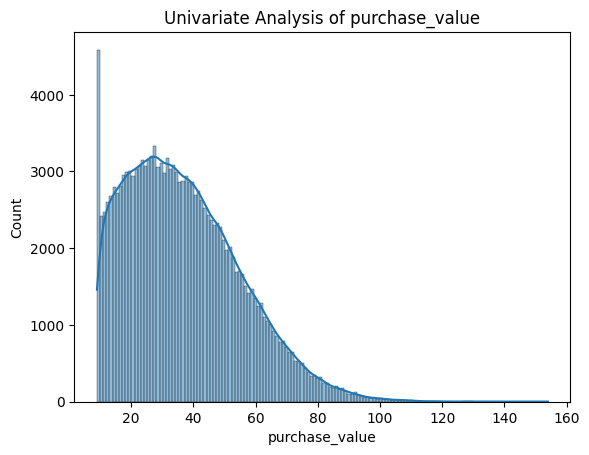

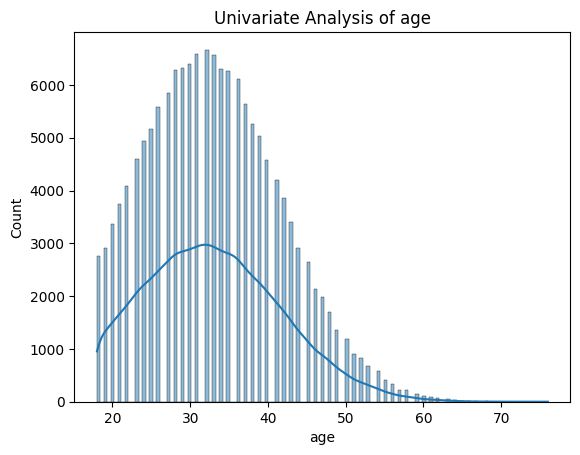

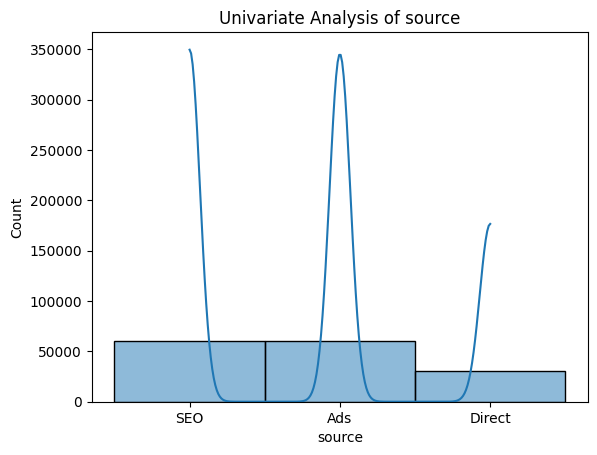

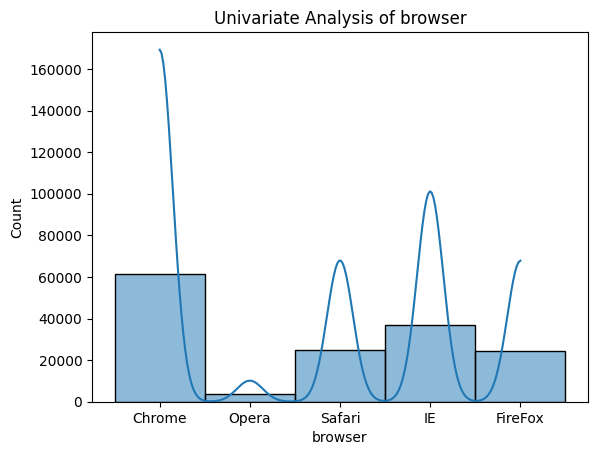

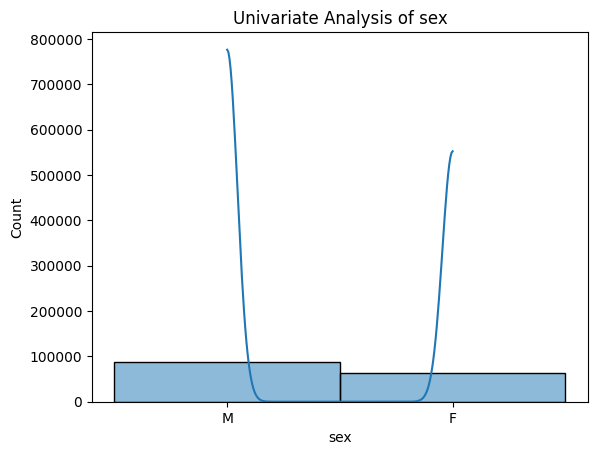

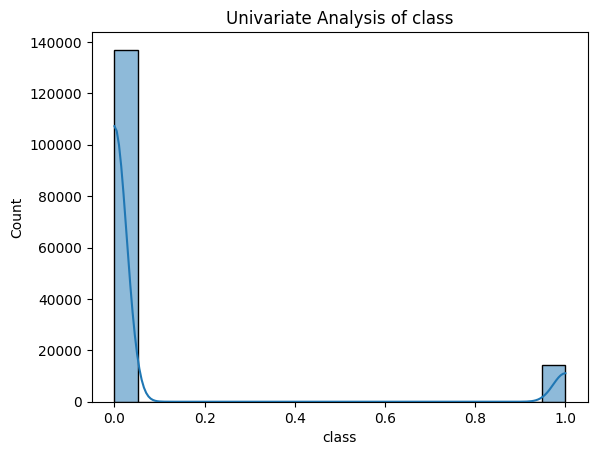

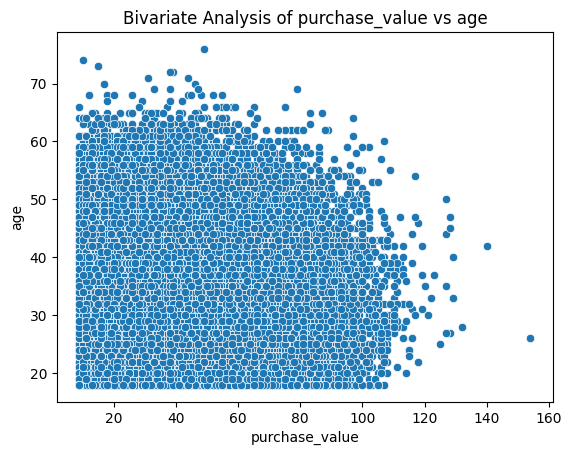

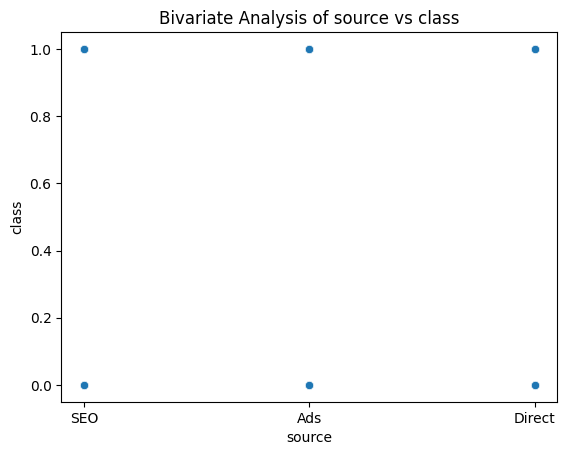

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Load Data
fraud_data = pd.read_csv(r'C:\Users\user\Desktop\Kifiya\Adey-Innovations-Fraud-Mgt\data\Fraud_Data.csv')
ip_data = pd.read_csv(r'C:\Users\user\Desktop\Kifiya\Adey-Innovations-Fraud-Mgt\data\IpAddress_to_Country.csv')

# 2. Data Cleaning
fraud_data = fraud_data.drop_duplicates()  # Remove duplicates

# Correct data types
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])
fraud_data['age'] = fraud_data['age'].astype(int)

# 3. Handle Missing Values (Imputation)
# Identify numeric and categorical columns
numeric_cols = fraud_data.select_dtypes(include=np.number).columns.tolist()
categorical_cols = fraud_data.select_dtypes(include='object').columns.tolist()

# Impute missing values in numeric columns with the mean
for col in numeric_cols:
    fraud_data[col] = fraud_data[col].fillna(fraud_data[col].mean())

# Impute missing values in categorical columns with the mode
for col in categorical_cols:
    fraud_data[col] = fraud_data[col].fillna(fraud_data[col].mode()[0]) #fillna with the most frequent value

# 4. Exploratory Data Analysis (EDA)
def univariate_analysis(df, relevant_columns):
    for col in relevant_columns:
        if col in df.columns:  # Check if the column exists
            plt.figure()
            sns.histplot(df[col], kde=True) # or sns.countplot(df[col]) for categorical
            plt.title(f'Univariate Analysis of {col}')
            plt.show()
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")

def bivariate_analysis(df, relevant_pairs):
    for x, y in relevant_pairs:
        if x in df.columns and y in df.columns:
            plt.figure()
            if x == 'signup_time' or x == 'purchase_time':
                sns.countplot(data=df, x=y, hue=x)  # Time vs. categorical
            elif y == 'signup_time' or y == 'purchase_time':
                sns.countplot(data=df, x=x, hue=y)  # Categorical vs. time
            else:
                sns.scatterplot(data=df, x=x, y=y) # Numerical vs. numerical
            plt.title(f'Bivariate Analysis of {x} vs {y}')
            plt.show()
        else:
            print(f"Warning: One or both columns not found for bivariate analysis.")

# Example EDA calls (customize columns as needed)
numeric_eda_cols = ['purchase_value', 'age']
categorical_eda_cols = ['source', 'browser', 'sex', 'class']
univariate_analysis(fraud_data, numeric_eda_cols + categorical_eda_cols)

bivariate_pairs = [('purchase_value', 'age'), ('source', 'class')]  # Add more pairs
bivariate_analysis(fraud_data, bivariate_pairs)




In [7]:
# 5. Merge Datasets for Geolocation Analysis
ip_data['lower_bound_ip_address'] = ip_data['lower_bound_ip_address'].astype(np.int64)
ip_data['upper_bound_ip_address'] = ip_data['upper_bound_ip_address'].astype(np.int64)
fraud_data['ip_address'] = fraud_data['ip_address'].astype(np.int64)

merged_data = pd.merge_asof(fraud_data.sort_values('ip_address'),
                           ip_data.sort_values('lower_bound_ip_address'),
                           left_on='ip_address',
                           right_on='lower_bound_ip_address',
                           direction='forward')

merged_data = merged_data.drop(columns=['lower_bound_ip_address', 'upper_bound_ip_address'])

merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093,0,Australia
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447,0,Australia
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818,0,Australia
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566,0,Australia
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423,0,Australia


In [8]:
# 6. Feature Engineering
# Time-based features
merged_data['signup_hour'] = merged_data['signup_time'].dt.hour
merged_data['signup_day_of_week'] = merged_data['signup_time'].dt.dayofweek  # Monday=0, Sunday=6
merged_data['purchase_hour'] = merged_data['purchase_time'].dt.hour
merged_data['purchase_day_of_week'] = merged_data['purchase_time'].dt.dayofweek

# Transaction Frequency (Proxy - explained in previous response)
merged_data['purchase_frequency_proxy'] = merged_data['purchase_value']

In [9]:
# 7. Normalization and Scaling (Example using StandardScaler)
scaler = StandardScaler()

# Select numeric features to scale (excluding time-based and proxy features)
numeric_features_to_scale = ['purchase_value', 'age', 'purchase_frequency_proxy'] # Add other relevant numeric features

merged_data[numeric_features_to_scale] = scaler.fit_transform(merged_data[numeric_features_to_scale])

# 8. Encode Categorical Features (Example using OneHotEncoder)
categorical_features_to_encode = ['source', 'browser', 'sex'] # Add other relevant categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # handle_unknown to avoid errors with new data

encoded_features = encoder.fit_transform(merged_data[categorical_features_to_encode])
encoded_feature_names = encoder.get_feature_names_out(categorical_features_to_encode) # Get the encoded feature names

encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names) # Create a DataFrame with the encoded features
merged_data = pd.concat([merged_data.reset_index(drop=True), encoded_df], axis=1) # Concatenate with the original DataFrame
merged_data = merged_data.drop(columns=categorical_features_to_encode) # Drop the original categorical columns

merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,country,signup_hour,...,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,0.494721,ZCLZTAJPCRAQX,0.331793,52093,0,Australia,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,-0.214781,YFGYOALADBHLT,-0.364448,93447,0,Australia,4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,-0.214781,QZNVQTUITFTHH,-0.132367,105818,0,Australia,16,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,-0.214781,PIBUQMBIELMMG,0.795954,117566,0,Australia,19,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,0.985915,WFIIFCPIOGMHT,0.563874,131423,0,Australia,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [11]:
merged_data.to_csv(r'C:\Users\user\Desktop\Kifiya\Adey-Innovations-Fraud-Mgt\data\merged_data.csv', index=False)